**<ins>Introduction</ins>**
==

In the context of online gaming platforms, identifying which players are most engaged can provide valuable insight for recruitment and retention strategies. Engagement is often measured by how much time players spend on the platform, and being able to predict this behavior based on other known characteristics could help platforms target specific player groups for marketing or community building.

In this project, we explore the question:
**Can we predict which players are most likely to contribute a large amount of data (i.e., total hours played) based on their experience level and whether they are subscribed to the game-related newsletter?**

This is a predictive modeling problem where the goal is to estimate a continuous numerical variable (hours played) using two categorical predictors (experience and subscription status). Since both predictors are non-numeric, we aim to apply a regression method that can handle categorical inputs effectively without requiring strong assumptions about the data.

<ins>players.csv</ins> Dataset
---

Observations: 196

Variables (7):

| Variable               | Type                | Description  |
|------------------------|---------------------|--------------|
| **experience**         |<chr\>| Player's level of in-game experience.|
| **subscribe**          |<lgl\>| Indicates if player is subscribed to in-game newsletters.|
| **hashedEmail**        |<chr\>| Player's anonymous email.|
| **played_hours**       |<dbl\>| Time playing session started (relative).|
| **name**               |<chr\>| Player's in-game name.|
| **gender**             |<chr\>| Player's gender.|
| **Age**                |<dbl\>| Player's age.|


**<ins>Methods & Results</ins>**
==

In [51]:
### Run this cell for initialization of packages
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(gridExtra)
options(repr.matrix.max.rows = 6)
source("cleanup.R")
set.seed(4)

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [52]:
set.seed(5)

# Set url's from github repository
players_url <- "https://raw.githubusercontent.com/Alonso181006/Individual-Project/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/Alonso181006/Individual-Project/refs/heads/main/sessions.csv"

# Read the data from the url's
players_data <- read_csv(players_url)
sessions_data <- read_csv(sessions_url)

# Count number of sessions for each user
sessions_data_count <- sessions_data |>
    group_by(hashedEmail) |>
    summarize(number_sessions = n())

# Renamed column
session_data_tidy <- sessions_data_count |>
    rename(hashed_email = hashedEmail)

# Combine Two Data Frames
players_data_combine <- players_data |>
    left_join(session_data_tidy, by = "hashed_email")

# Update Data Frame to replace NA values, and set subscribe column as a factor 
players_data_update <- players_data_combine |>
    mutate(number_sessions = replace_na(number_sessions, 0), 
          subscribe = as.factor(subscribe)) 

# Add a column that sets the experience level as a rank from 1-5 (inclusive)
players_data <- players_data_update|>
    mutate(rank = as.integer(factor(experience, 
                                    levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))))
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashed_email, name, gender
dbl (2): played_hours, age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age,number_sessions,rank
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,5
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,4
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,1,2
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,6,2
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,1,5


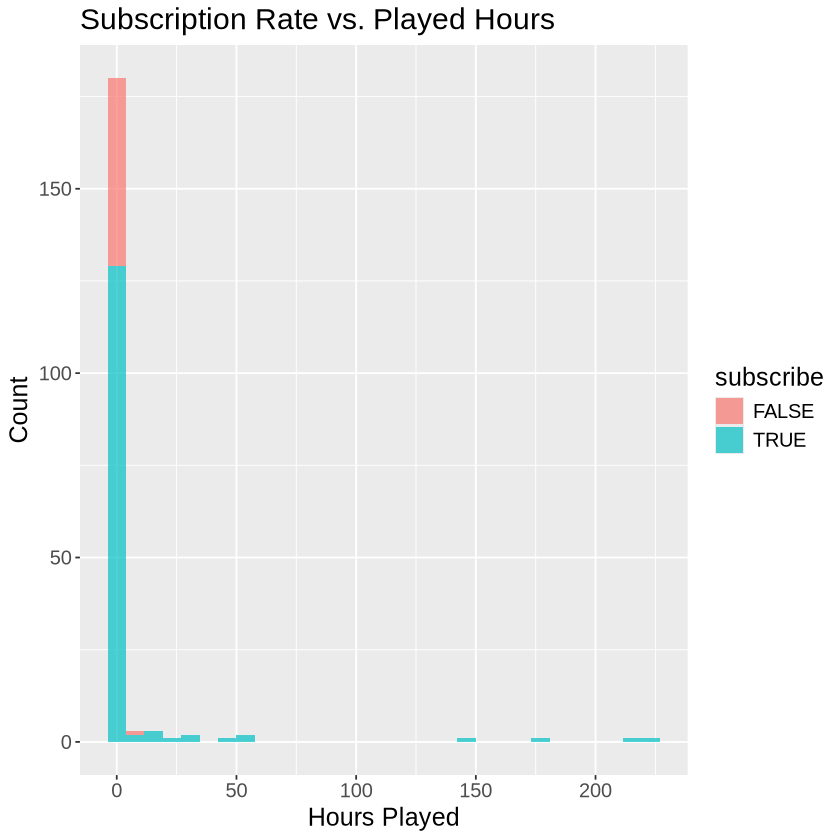

In [53]:
# Plot to Visualize Relationship between Subscribe & Played Hours, Experience, & Age
subscription_plot <- ggplot(players_data, aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 30, alpha = 0.7) +
    labs(title = "Subscription Rate vs. Played Hours", x = "Hours Played", y = "Count") +
    theme(text = element_text(size = 15))
subscription_plot

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 26 rows.
               ✖ Assigned data has 27 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 27 to size 26.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





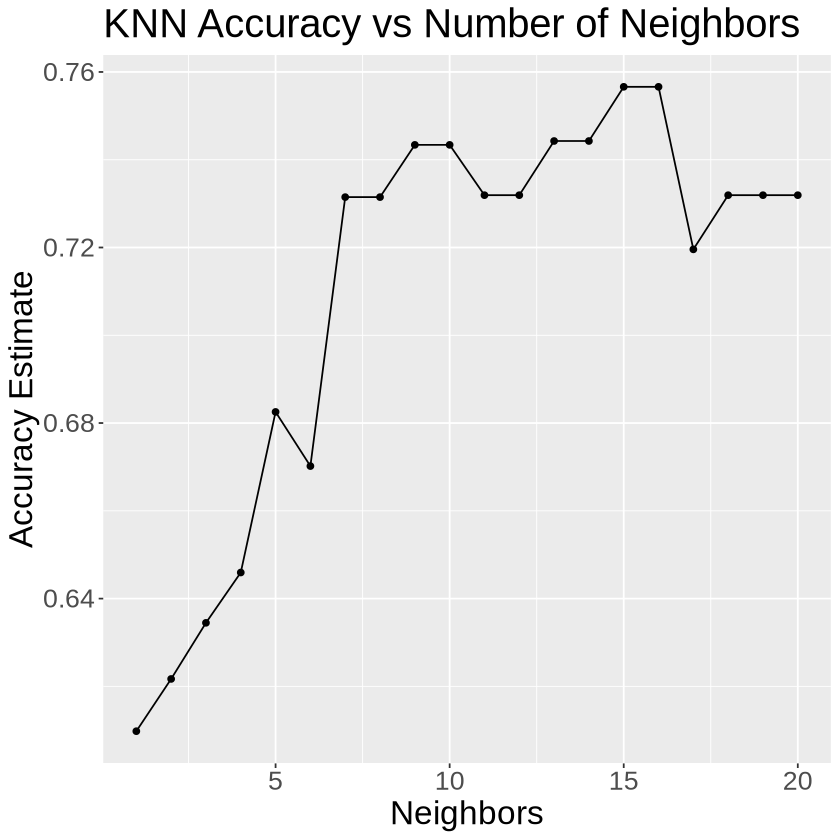

In [56]:
# Set seed to prevent different splits of data
set.seed(5)

# Split data into training and testing sets at 30/70 split
players_split <- initial_split(players_data, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

# Create players recipe for Classification
players_recipe <- recipe(subscribe ~ age + played_hours + rank, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create player knn-model, tuning the neighbor value
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Perform cross-validation using 5-fold
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# Create a tibble of possible 'neighbors' values 1 to 10
gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Setup workflow to test k values with cross-validation
players_wkflw <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = players_vfold, grid = gridvals)

# Collect and Filter the metrics for evaluation.
players_results <- players_wkflw |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# Pull Best K value
best_k = players_results |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Plot the Accuracy vs Neighbors estimate
players_plot <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy vs Number of Neighbors") +
    theme(text = element_text(size = 20))

#Display Plot
players_plot

In [57]:
# Set seed 
set.seed(5)

# Re-create player model using the optimal k value
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification") 

# Fit the workflow to the player traing data
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

# Predict the subcription of players in test set
players_summary <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) 

# Compute & Display accuracy of the Knn Classfication on test dataset
players_accuracy <- players_summary |>
    metrics( truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_accuracy

# Compute & Display precision of the Knn Classfication on test dataset
players_precision <- players_summary |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")
players_precision

# Compute & Display recall of the Knn Classfication on test dataset
players_recall <- players_summary |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")
players_recall

# Compute & Display confusion matrix of the Knn Classfication on test dataset
players_matrix <- players_summary |>
    conf_mat(truth = subscribe, estimate = .pred_class)
players_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7666667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7586207


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


          Truth
Prediction FALSE TRUE
     FALSE     2    0
     TRUE     14   44

**<ins>Discussion</ins>**
==

**<ins>References</ins>**
==